In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/CSV_files/Binance Coin - Historic data.csv')

In [4]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0
df['Vol.'] = df['Vol.'].apply(value_to_float)
df.head(5)

,Date,Price(in dollars),Open,High,Low,Vol.,Change%
0,"Jul 27, 2021",303.29,304.31,307.62,298.53,2260000.0,-0.33
1,"Jul 26, 2021",304.31,302.60,327.62,301.19,2860000.0,0.58
2,"Jul 25, 2021",302.57,302.55,303.09,292.85,1250000.0,-0.19
3,"Jul 24, 2021",303.15,298.91,305.01,296.16,1810000.0,1.42
4,"Jul 23, 2021",298.89,293.51,301.15,281.68,1980000.0,1.83


In [5]:
df = df[::-1].reset_index(drop=True)
df.head(5)

,Date,Price(in dollars),Open,High,Low,Vol.,Change%
0,"Nov 09, 2017",1.99,1.99,2.20,1.90,283350.0,0.00
1,"Nov 10, 2017",1.71,1.99,2.02,1.60,483230.0,-14.07
2,"Nov 11, 2017",1.66,1.71,1.93,1.58,256710.0,-2.92
3,"Nov 12, 2017",1.49,1.66,1.70,1.34,456480.0,-10.24
4,"Nov 13, 2017",1.68,1.49,1.74,1.49,166010.0,12.75


In [6]:
data_training=df.iloc[:df[df['Date'] == 'Jan 01, 2021'].index[0]]
data_training

,Date,Price(in dollars),Open,High,Low,Vol.,Change%
0,"Nov 09, 2017",1.99,1.99,2.20,1.90,283350.0,0.00
1,"Nov 10, 2017",1.71,1.99,2.02,1.60,483230.0,-14.07
2,"Nov 11, 2017",1.66,1.71,1.93,1.58,256710.0,-2.92
3,"Nov 12, 2017",1.49,1.66,1.70,1.34,456480.0,-10.24
4,"Nov 13, 2017",1.68,1.49,1.74,1.49,166010.0,12.75
...,...,...,...,...,...,...,...
1144,"Dec 27, 2020",33.68,33.60,34.97,31.97,4900000.0,0.26
1145,"Dec 28, 2020",35.94,33.64,36.09,33.35,5580000.0,6.72
1146,"Dec 29, 2020",39.10,35.94,39.70,35.31,9680000.0,8.80
1147,"Dec 30, 2020",38.10,39.14,39.21,36.84,3380000.0,-2.56


In [7]:
data_test=df.iloc[df[df['Date'] == 'Jan 01, 2021'].index[0]:]
data_test

,Date,Price(in dollars),Open,High,Low,Vol.,Change%
1149,"Jan 01, 2021",37.72,37.33,38.93,36.98,3240000.0,1.04
1150,"Jan 02, 2021",38.23,37.73,38.46,36.81,3940000.0,1.35
1151,"Jan 03, 2021",41.22,38.24,41.64,37.78,6340000.0,7.81
1152,"Jan 04, 2021",41.10,41.25,43.21,38.09,6870000.0,-0.29
1153,"Jan 05, 2021",41.79,41.12,41.79,38.86,4880000.0,1.68
...,...,...,...,...,...,...,...
1352,"Jul 23, 2021",298.89,293.51,301.15,281.68,1980000.0,1.83
1353,"Jul 24, 2021",303.15,298.91,305.01,296.16,1810000.0,1.42
1354,"Jul 25, 2021",302.57,302.55,303.09,292.85,1250000.0,-0.19
1355,"Jul 26, 2021",304.31,302.60,327.62,301.19,2860000.0,0.58


In [8]:
training_data = data_training.drop(['Date', 'Change%', 'Open', 'High', 'Low'], axis = 1)
training_data.head()

,Price(in dollars),Vol.
0,1.99,283350.0
1,1.71,483230.0
2,1.66,256710.0
3,1.49,456480.0
4,1.68,166010.0


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
training_data = scaler.fit_transform(training_data)
training_data

array([[0.01329434, 0.0116557 ],
       [0.00584951, 0.01987783],
       [0.00452007, 0.01055985],
       ...,
       [1.        , 0.39819005],
       [0.97341133, 0.13903743],
       [0.95320394, 0.10571781]])

In [10]:
X_train,Y_train=[], []
training_data.shape[0]
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    Y_train.append(training_data[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(1089, 60, 2)

In [13]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 2)))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units =1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)              

In [14]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history= model.fit(X_train, Y_train, epochs=20, batch_size=50, validation_split=0.1)

Epoch 1/20
20/20 [==============================] - 18s 422ms/step - loss: 0.0926 - val_loss: 0.1503
Epoch 2/20
20/20 [==============================] - 7s 375ms/step - loss: 0.0249 - val_loss: 0.0621
Epoch 3/20
20/20 [==============================] - 7s 372ms/step - loss: 0.0147 - val_loss: 0.0058
Epoch 4/20
20/20 [==============================] - 8s 379ms/step - loss: 0.0134 - val_loss: 0.0100
Epoch 5/20
20/20 [==============================] - 7s 373ms/step - loss: 0.0122 - val_loss: 0.0141
Epoch 6/20
20/20 [==============================] - 7s 373ms/step - loss: 0.0104 - val_loss: 0.0158
Epoch 7/20
20/20 [==============================] - 8s 379ms/step - loss: 0.0100 - val_loss: 0.0158
Epoch 8/20
20/20 [==============================] - 8s 377ms/step - loss: 0.0100 - val_loss: 0.0149
Epoch 9/20
20/20 [==============================] - 8s 377ms/step - loss: 0.0087 - val_loss: 0.0156
Epoch 10/20
20/20 [==============================] - 8s 375ms/step - loss: 0.0096 - val_loss: 0.012

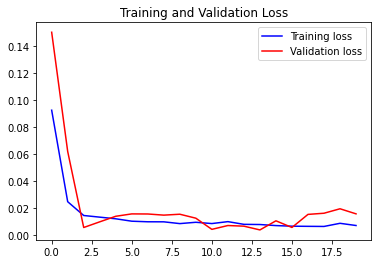

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [16]:
part_60_days = data_training.tail(60)
df= part_60_days.append(data_test, ignore_index = True)
df = df.drop(['Date', 'Change%', 'Open', 'High', 'Low'], axis = 1)
df.head()

,Price(in dollars),Vol.
0,27.80,2950000.0
1,26.87,3630000.0
2,26.94,3010000.0
3,27.69,3380000.0
4,29.06,3830000.0


In [17]:
inputs = scaler.fit_transform(df)
inputs

array([[1.43145192e-03, 9.95277940e-02],
       [0.00000000e+00, 1.33024572e-01],
       [1.07743693e-04, 1.02483392e-01],
       [1.26214041e-03, 1.20709580e-01],
       [3.37083840e-03, 1.42876565e-01],
       [1.36988410e-03, 1.68984348e-01],
       [2.32418538e-03, 1.12335386e-01],
       [1.87781865e-03, 1.04453791e-01],
       [2.03173821e-03, 1.01990792e-01],
       [1.72389909e-03, 8.52424034e-02],
       [1.29292432e-03, 6.75088151e-02],
       [2.03173821e-03, 8.47498037e-02],
       [1.60076344e-03, 5.76568216e-02],
       [1.21596454e-03, 5.47012235e-02],
       [1.67772322e-03, 7.04644131e-02],
       [2.60124059e-03, 1.04946390e-01],
       [1.84703474e-03, 1.05931590e-01],
       [1.89321061e-03, 9.06609998e-02],
       [3.21691884e-03, 1.19231781e-01],
       [5.58728009e-03, 1.63073152e-01],
       [4.87925010e-03, 1.47309962e-01],
       [6.32609398e-03, 1.48295162e-01],
       [1.08359371e-02, 4.33017774e-01],
       [6.80324462e-03, 2.63563486e-01],
       [2.077914

In [18]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i]) 
    Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test) 
X_test.shape, Y_test.shape
Y_pred = model.predict(X_test)
Y_pred, Y_test
scaler.scale_

array([1.53919562e-03, 4.92599675e-08])

In [22]:
scale=1/(1.53919562e-03)
Y_test = Y_test*scale
Y_pred = Y_pred*scale
Y_pred

array([[119783.13 ],
       [116431.96 ],
       [114181.414],
       [110516.195],
       [107429.625],
       [105387.38 ],
       [104376.45 ],
       [101147.484],
       [ 97671.484],
       [ 94134.43 ],
       [ 90400.07 ],
       [ 86658.8  ],
       [ 83496.96 ],
       [ 80062.89 ],
       [ 76973.9  ],
       [ 74819.445],
       [ 73294.555],
       [ 71927.47 ],
       [ 70606.17 ],
       [ 69520.88 ],
       [ 68714.15 ],
       [ 67873.484],
       [ 67112.625],
       [ 66868.79 ],
       [ 66572.75 ],
       [ 67088.71 ],
       [ 66124.99 ],
       [ 65397.31 ],
       [ 64834.   ],
       [ 64396.477],
       [ 64097.9  ],
       [ 63649.625],
       [ 63256.953],
       [ 63012.06 ],
       [ 62863.594],
       [ 62764.164],
       [ 62748.4  ],
       [ 62871.633],
       [ 63064.84 ],
       [ 63330.44 ],
       [ 63745.473],
       [ 64391.258],
       [ 65234.47 ],
       [ 66198.59 ],
       [ 67171.93 ],
       [ 68078.22 ],
       [ 68883.69 ],
       [ 6954

In [23]:
Y_test

array([  7049.1164075 ,   7380.45736306,   9323.02492604,   9245.06234826,
         9693.34717049,   9953.22242975,  10895.27024458,  10044.1787705 ,
        11018.71099273,  10109.14758531,   7399.9480075 ,   7393.45112602,
         8608.36796307,   9751.81910383,   9121.62160011,  10544.43864458,
        12285.60288164,  12006.23697793,  10232.58833346,  10200.10392605,
         7672.81702973,   9095.63407419,   9128.1184816 ,   9712.83781494,
         9686.85028901,   9660.86276308,   9173.59665197,  10135.13511124,
        10395.0103705 ,  11622.92097052,  11304.57377792,  15949.84403724,
        15670.47813353,  16411.12262243,  18704.52178542,  26559.25149663,
        29697.24525223,  26981.54879293,  34329.52174858,  52449.32420066,
        66170.73788972,  63123.70047487,  71238.30544534,  68996.8813342 ,
        70887.47384534,  66989.3449564 ,  67060.81065269,  89988.30540113,
       109712.83757916, 198720.11387657, 147797.55682408, 173395.26986144,
       156288.98092048, 1

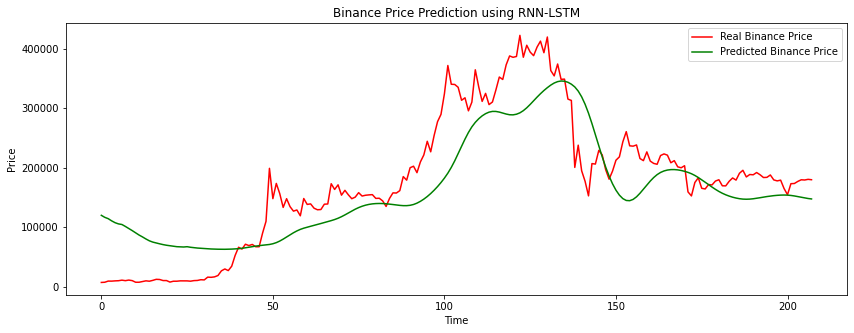

In [24]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Binance Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Binance Price')
plt.title('Binance Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()